In [20]:
%reload_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.ops.focal_loss import sigmoid_focal_loss
from torch.utils.data import DataLoader
from DatasetClass import KITTI_MOD_FIXED_Dataset
from ModelClass import UNET
from torch.utils.tensorboard import SummaryWriter
import sys
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

# set device and clean up
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gc.collect()
torch.cuda.empty_cache()
print(f"running on '{device}'")


# dataset
data_root = '/storage/remote/atcremers40/motion_seg/datasets/KITTI_MOD_fixed/training/'
data_transforms = transforms.Compose([
    transforms.ToTensor()
])
dataset = KITTI_MOD_FIXED_Dataset(data_root, data_transforms)


# specify some hyperparams
lr = 1e-5
batch_size = 1
epochs = 100

# data split and data loader
train_size = int(0.8 *  len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)

# init model and pass to `device`
input_channels=6
output_channels=1
model = UNET(in_channels=input_channels, out_channels=output_channels).to(device)
model = model.float()
# print(model)

[data, targets] = next(iter(train_loader))

# loss and optimizer (Note: focal_loss can not be instantiated as it is not a class. (Use
# directly in when needed)
# criterion = sigmoid_focal_loss()
optimizer = optim.Adam(model.parameters(), lr=lr)

running on 'cuda:0'


In [21]:
def run_val(loader, model):
    model.eval()
    
    val_losses = []
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            x = x.to(device=device).float()
            y = y.to(device=device).float()

            # forward
            scores = model(x)
            loss = sigmoid_focal_loss(scores, y, reduction="mean")
            val_losses.append(loss.item())

            if batch_idx == 10:  # ghetto way of running 10 val batches 
                break
            

    # set back to train ensures layers like dropout, batchnorm are used after eval
    model.train()
    return sum(val_losses)/len(val_losses)

In [22]:
# train network
print("train network ...")
train_loss = []
val_loss = []
for epoch in range(epochs):
    model.train()
    losses = []

    # for batch_idx, (data, targets) in enumerate(train_loader):

    # move data to gpu if available
    data = data.to(device).float()
    targets = targets.to(device).float()

    # forward
    scores = model(data)
    loss = sigmoid_focal_loss(scores, targets, reduction="mean")

    losses.append(loss.item())

    # backward
    optimizer.zero_grad()
    loss.backward()

    # adam step
    optimizer.step()

    # print(f"Epoch {epoch}: loss => {sum(losses)/len(losses)}")
    train_loss.append(sum(losses)/len(losses))
    val_loss.append(run_val(val_loader, model))
    print(f"epoch {epoch + 1}: training loss {loss.item()}, val loss {val_loss[-1]}")

train network ...
epoch 1: training loss 519388.75, val loss 7917.140919824893
epoch 2: training loss 366781.75, val loss 7423.633226820014
epoch 3: training loss 260457.78125, val loss 7060.538800326261


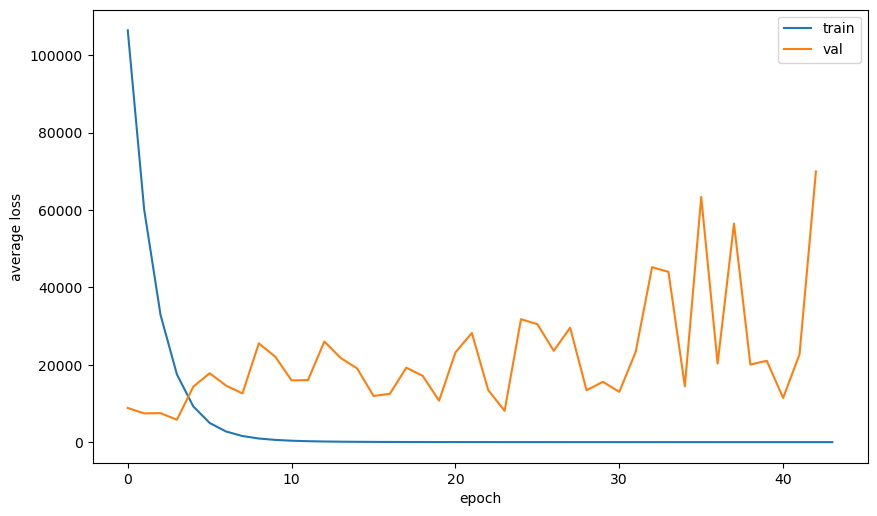

In [19]:
# plot losses for train and val
ax1 = list(range(len(train_loss)))
fig = plt.figure(figsize=(10,6), dpi=100)
plot_train = plt.plot(ax1, train_loss)
plot_val = plt.plot(list(range(len(val_loss))), val_loss)
plt.xlabel("epoch")
plt.ylabel("average loss")
plt.legend(["train", "val"])
plt.show()

In [ ]:
  # save model weights
model_filename = "/storage/remote/atcremers62/w0017/week4/trained_u_net.pt"
torch.save(model, model_filename)